In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

In [2]:
PATH = './celebA/'

batch_size = 128

img_size = 64

z_size = 100

epochs = 8

learning_rate = 0.0002

# Beta1 hyperparameter(for Adam)
beta1 = 0.5

real_label = 1
fake_label = 0

In [3]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_dataset = dataset.ImageFolder(root=PATH,
                           transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=img_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

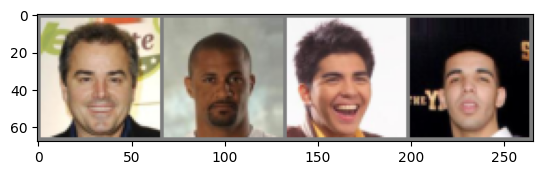

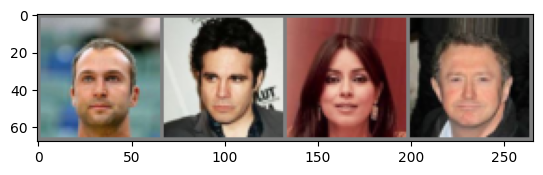

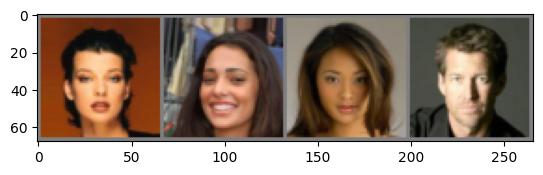

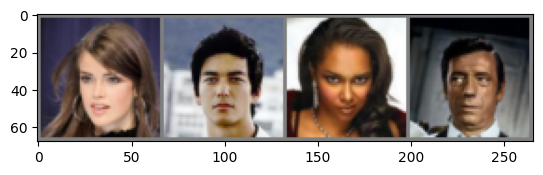

In [8]:
def imgshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

for i in range(4):
    sample_data_loader = torch.utils.data.DataLoader(dataset=img_dataset,
                                                    batch_size=4,
                                                    shuffle=True)
    inputs, classes = next(iter(sample_data_loader))
    out = torchvision.utils.make_grid(inputs)
    imgshow(out)

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_size,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=512,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.ReLU(inplace=True)
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=256,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.ReLU(inplace=True)
        )
        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=128,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.ReLU(inplace=True)
        )
        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=64,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.ReLU(inplace=True)
        )
        self.upconv5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=3,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.upconv5(x) 

        return x

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=64,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=128,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=256,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
                bias=False
                ),
            nn.BatchNorm2d(
                num_features=512,
                eps=1e-05,
                momentum=0.1,
                affine=True,
                track_running_stats=True
                ),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=(4, 4),
                stride=(1, 1), bias=False
                ),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x

In [56]:
model_G = Generator()
model_D = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_G.to(device)
model_D.to(device)

print(f"Device: {device}")
print("------------------------------------------------------------------------------------------------------------")
print(model_G)
print(model_D)

Device: cuda
------------------------------------------------------------------------------------------------------------
Generator(
  (upconv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, e

In [57]:
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [58]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3), cmap='Greys_r')
    return fig

[0/8][400/1582]	Loss_D: 0.0063	Loss_G: 7.3195	
[0/8][800/1582]	Loss_D: 1.2276	Loss_G: 22.0290	
[0/8][1200/1582]	Loss_D: 0.2608	Loss_G: 4.3481	
[1/8][400/1582]	Loss_D: 0.4305	Loss_G: 3.5320	
[1/8][800/1582]	Loss_D: 0.2114	Loss_G: 4.7362	
[1/8][1200/1582]	Loss_D: 1.1207	Loss_G: 7.9381	
[2/8][400/1582]	Loss_D: 0.3948	Loss_G: 4.9820	
[2/8][800/1582]	Loss_D: 0.2026	Loss_G: 3.6592	
[2/8][1200/1582]	Loss_D: 0.8696	Loss_G: 3.0634	
[3/8][400/1582]	Loss_D: 0.1980	Loss_G: 3.8239	
[3/8][800/1582]	Loss_D: 0.2631	Loss_G: 3.8639	
[3/8][1200/1582]	Loss_D: 0.3617	Loss_G: 2.7113	
[4/8][400/1582]	Loss_D: 0.3692	Loss_G: 1.1272	
[4/8][800/1582]	Loss_D: 0.1035	Loss_G: 4.0125	
[4/8][1200/1582]	Loss_D: 0.4676	Loss_G: 5.2594	
[5/8][400/1582]	Loss_D: 0.1589	Loss_G: 4.3070	
[5/8][800/1582]	Loss_D: 0.1271	Loss_G: 5.4806	
[5/8][1200/1582]	Loss_D: 0.2273	Loss_G: 4.2329	
[6/8][400/1582]	Loss_D: 0.5015	Loss_G: 3.9039	
[6/8][800/1582]	Loss_D: 0.1062	Loss_G: 3.8760	
[6/8][1200/1582]	Loss_D: 0.4602	Loss_G: 2.7666	


/tmp/ipykernel_284689/2905744346.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4, 4))


[7/8][400/1582]	Loss_D: 0.1889	Loss_G: 3.8709	
[7/8][800/1582]	Loss_D: 0.2594	Loss_G: 1.9882	
[7/8][1200/1582]	Loss_D: 0.0873	Loss_G: 4.4664	


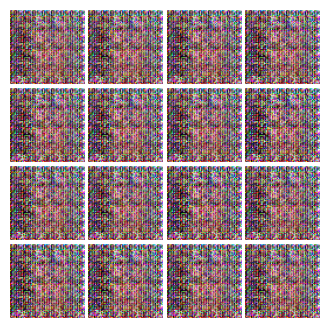

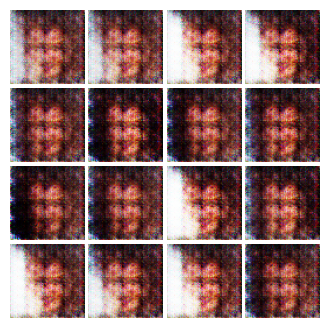

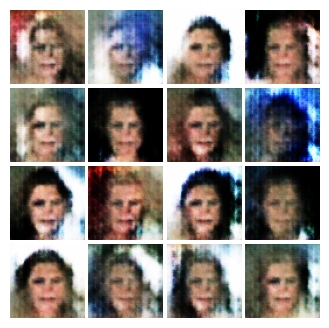

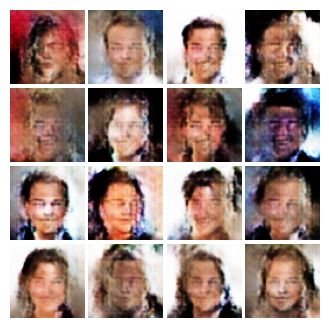

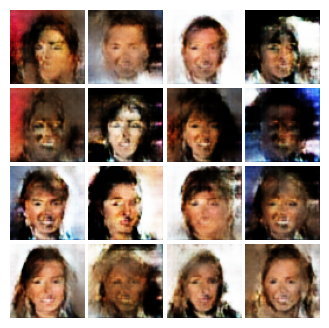

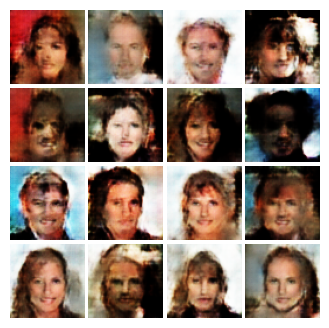

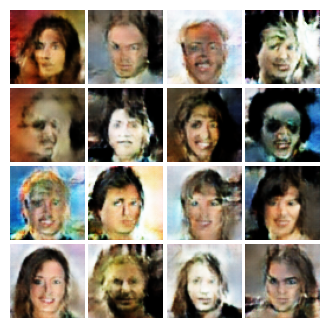

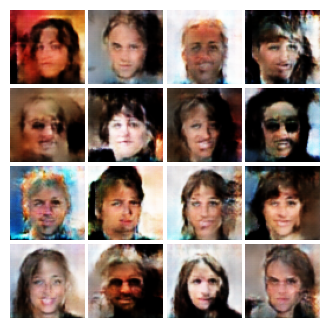

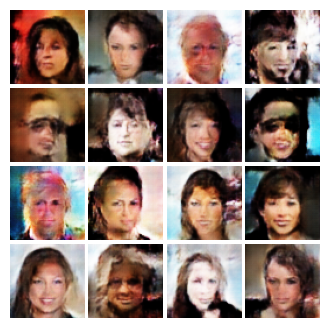

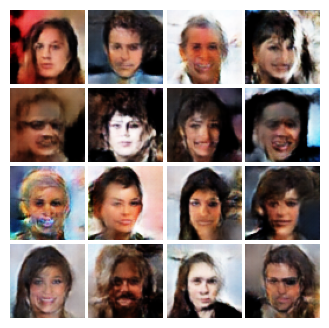

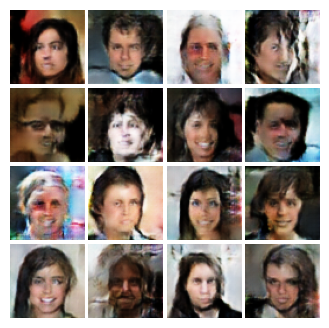

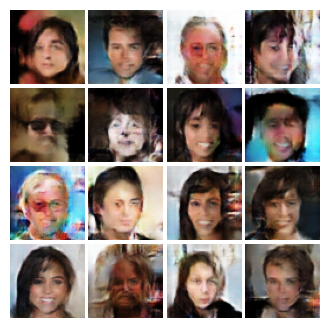

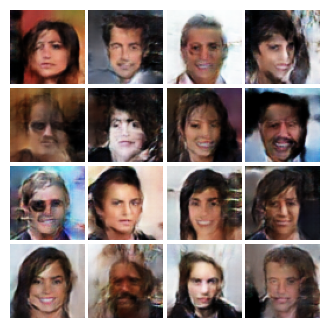

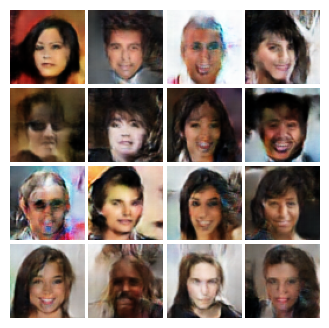

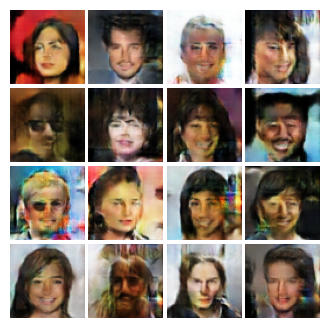

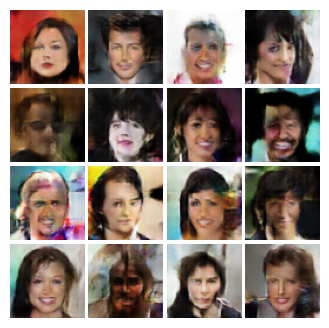

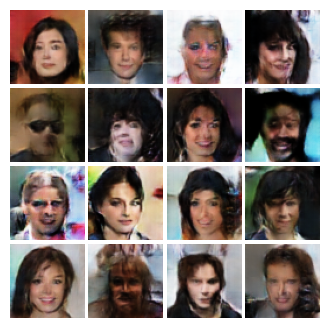

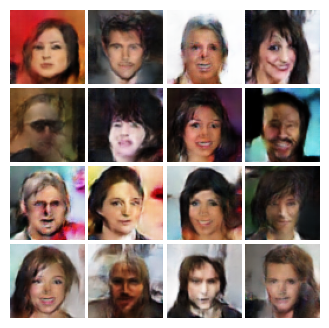

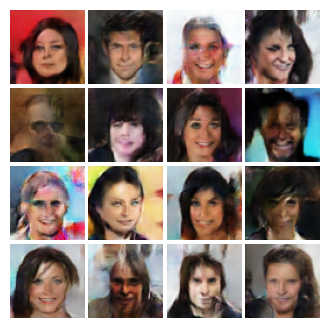

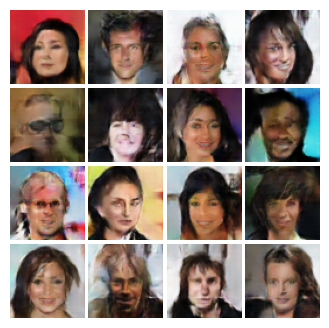

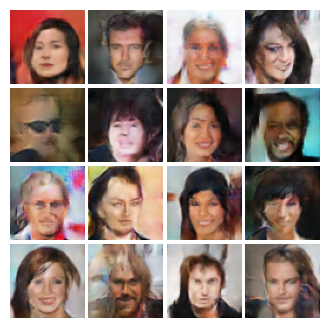

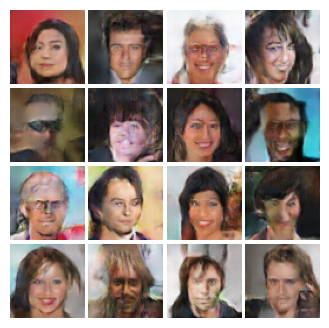

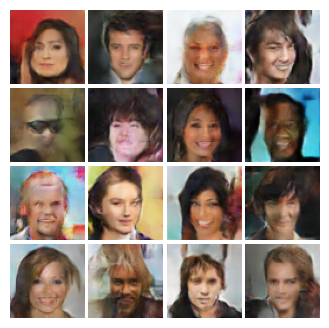

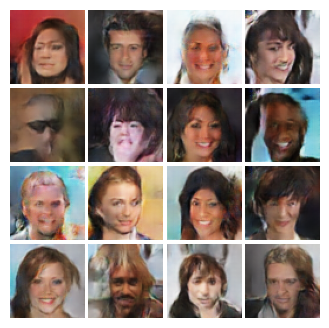

In [64]:
label_real = torch.full((batch_size,), real_label, device=device, dtype=torch.float)
label_fake = torch.full((batch_size,), fake_label, device=device, dtype=torch.float)

fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device, dtype=torch.float)

for epoch in range(epochs):
    model_G.train()
    model_D.train()

    for i, data in enumerate(data_loader):
        data = data[0].to(device)

        noise = torch.randn(batch_size, z_size, 1, 1, device=device, dtype=torch.float)
        fake_data = model_G(noise)

        # Discriminator 학습
        model_D.zero_grad()

        output_real = model_D(data).view(-1)
        Loss_D_real = criterion(output_real, label_real)
        Loss_D_real.backward()

        output_fake = model_D(fake_data.detach()).view(-1)
        Loss_D_fake = criterion(output_fake, label_fake)
        Loss_D_fake.backward()

        Loss_D = Loss_D_real + Loss_D_fake
        optimizer_D.step()


        # Generator 학습
        model_G.zero_grad()

        output = model_D(fake_data).view(-1)
        Loss_G = criterion(output, label_real)

        Loss_G.backward()
        optimizer_G.step()


        # Output training stats
        if i % 400 == 0 and i != 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, epochs, i, len(data_loader),
                     Loss_D.item(), Loss_G.item()))

            model_G.eval()
            model_D.eval()
            with torch.no_grad():
                output = model_G(fixed_noise).detach().cpu().numpy()
                output = np.transpose((output+1)/2, (0, 2, 3, 1))
                fig = plot(output[:16])

            model_G.train()
            model_D.train()




In [72]:
torch.save(model_G.state_dict(), 'model_G_state_dict')
torch.save(model_D.state_dict(), 'model_D_state_dict')